# Analysis of 2D parallel racetrack resonators structure

The resonant frequency and second-order dispersion $D_2$ of the supermodes are analyzed

Author: Weihao Xu

Date: May. 9th, 2025

Reference: 1. Ji QX, Liu P, Jin W, et al. Multimodality integrated microresonators using the Moiré speedup effect. Science. 2024;383(6687):1080-1083. doi:10.1126/science.adk9429

In [56]:
import numpy as np
import matplotlib.pyplot as plt
from Functions import *
from collections import namedtuple
from scipy.interpolate import CubicSpline

In [57]:
# folder to store results
foldername  = "./results/2D parallel racetracks/"

In [58]:
freq_1550   = c/(1550*1e-9)

## How the effective and group refractive index change at different wavlengths

In [96]:
# Fit polynomials for the refractive index of Si3N4 and SiO2
# from https://refractiveindex.info/?shelf=main&book=SiO2&page=Malitson
# Silicon nitride (Luke el.al. 2015.)
def n_Si3N4(wavl_um):
    return (1+3.0249/(1-(0.1353406/wavl_um)**2)+
            40314/(1-(1239.842/wavl_um)**2))**0.5
# Silicon oxide (Malitson 1965)
def n_SiO2(wavl_um):
    return (1+0.6961663/(1-(0.0684043/wavl_um)**2)+
            0.4079426/(1-(0.1162414/wavl_um)**2)+
            0.8974794/(1-(9.896161/wavl_um)**2))**0.5

In [97]:
# Load index data from a txt file
def Load_n(filename):
    n_list = []
    with open(filename,'r') as f:
        data_read = f.readlines()
        for line in data_read[1:]:
            wavl = float(line.split(',')[0].replace(" ","").replace("\n",""))
            n = float(line.split(',')[1].replace(" ","").replace("\n",""))
            n_list.append([wavl,n])
    n_list = np.array(n_list)
    return n_list

In [99]:
num_of_pts  = 1000

In [101]:
filename_neff   = foldername + "neff_L_inner_2_8_1500_1600.txt"
neff_arr        = Load_n(filename_neff)
filename_ng     = foldername + "ng_L_inner_2_8_1500_1600.txt"
ng_arr          = Load_n(filename_ng)

wavl_arr    = neff_arr[:,0]                   #unit: um
wavl_arr_intp = np.linspace(np.min(wavl_arr),np.max(wavl_arr),num_of_pts)

# effective index
neff_intp   = Interpolation(wavl_arr, neff_arr[:,1], wavl_arr_intp)
neff_1550   = neff_intp[np.argmin(np.abs(wavl_arr_intp-1.55))]

# group index
ng_intp     = Interpolation(wavl_arr, ng_arr[:,1], wavl_arr_intp)
# ng_1550     = ng_intp[np.argmin(np.abs(wavl_arr_intp-1.55))]

ng_1550     = 1.575

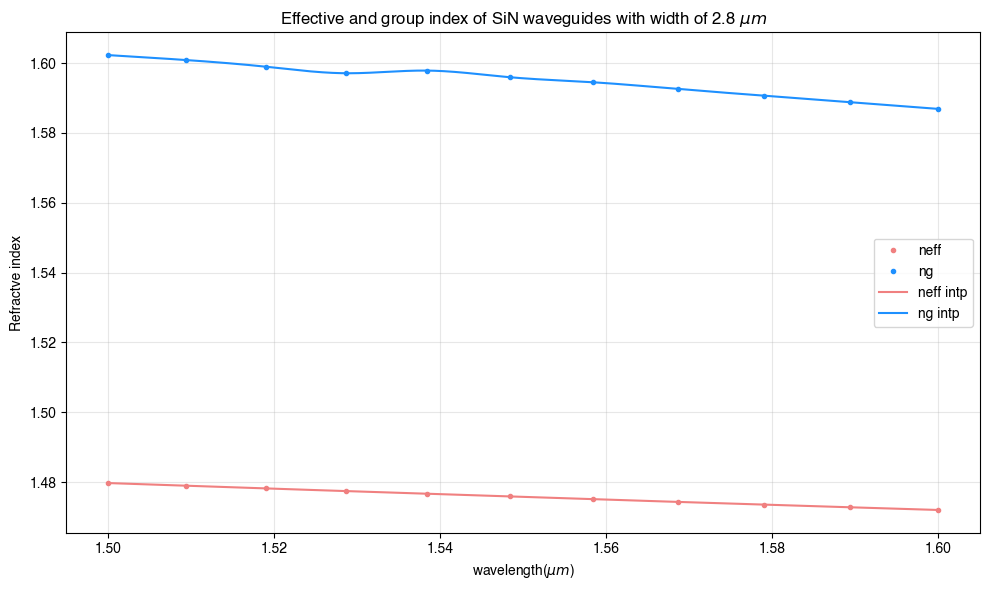

In [102]:
data_arr =  (   np.c_[wavl_arr, neff_arr[:,1], ng_arr[:,1]],
                np.c_[wavl_arr_intp, neff_intp, ng_intp],)
param_dict = {  "figsize"         : (10,6),
                "title"           : r"Effective and group index of SiN waveguides with width of 2.8 $\mu m$",
                "Y_legends"       : ["neff","ng","neff intp","ng intp"],
                "X_label"         : r'wavelength($\mu m$)',
                "Y_label"         : r"Refractve index",
                "marker_list"     : [".",".","",""]*10,
                "linestyle_list"  : ["","","-","-"]*10,
                "colors_list"     : ['lightcoral','dodgerblue']*3,
                "autoset_yticks"  : 0,
                # "ylim"            : (1,2),
                "foldername"      : foldername
                }
Plot_curve(data_arr, **param_dict)


## Defining parameters of the vernier resonators    
| Parameter  <img width=100/>|<img width=300/>  Meaning                      
| ----             | ----                         
| L1               | cavity length of the shorter resonator (resonator 1)
| L2               | cavity length of the longer resonator (resonator 2)
| D1               | FSR of resonator 1
| D2               | FSR of resonator 2
| D_ave            | FSR of a resonator whose length equals the average of L1 and L2
| $\epsilon$       | relative length difference of the two resonators defined as $\epsilon = \frac{L_2-L_1}{L_1+L_2}$



In [64]:
L1      = 9.5 * mm
# L1      = c/(ng_1550 * 20*1e9)
L2      = L1 * 1.005
D1      = c/(ng_1550 * L1) *2* np.pi
D2      = c/(ng_1550 * L2) *2* np.pi
D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
# D_ave   = 19.9766 * 2 *np.pi * 1e9
epsilon = (L2-L1)/(L1+L2)
M       = 1/(2*epsilon)

In [65]:
Max_M_idx   = 3
num_of_pts  = 1000
m_arr_intp  = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)

## Find coupling strength $g_{co}$ at different wavls

In [66]:
# Load kappa under different wavls of two coupled WGs width 2.8um
def Load_kappa_data(filename_kappa = "./results/2D parallel racetracks/straight_WG_Kappa.txt"):
    Kappa_arr = []
    with open (filename_kappa,'r') as f:
        read_data = f.readlines()
        for line in read_data[1:]:
            line_strip = line.strip()
            wavl = float(line_strip.split(",")[0])
            freq = c/wavl * 1e9
            K_12 = str2complex(line_strip.split(",")[1])
            K_21 = str2complex(line_strip.split(",")[2])
            Kappa = (K_12+K_21)/2
            Kappa = np.real(Kappa)
            Kappa_arr.append([freq,Kappa])
        Kappa_arr = np.array(Kappa_arr)
    return Kappa_arr

In [67]:
g_arr       = Load_kappa_data()
g_arr       = np.flip(g_arr,axis=0)
freq_arr        = g_arr[:,0]
freq_arr_intp   = freq_1550 + m_arr_intp * D_ave/(2*np.pi)
g_arr_intp      = Interpolation(freq_arr,g_arr[:,1],freq_arr_intp)

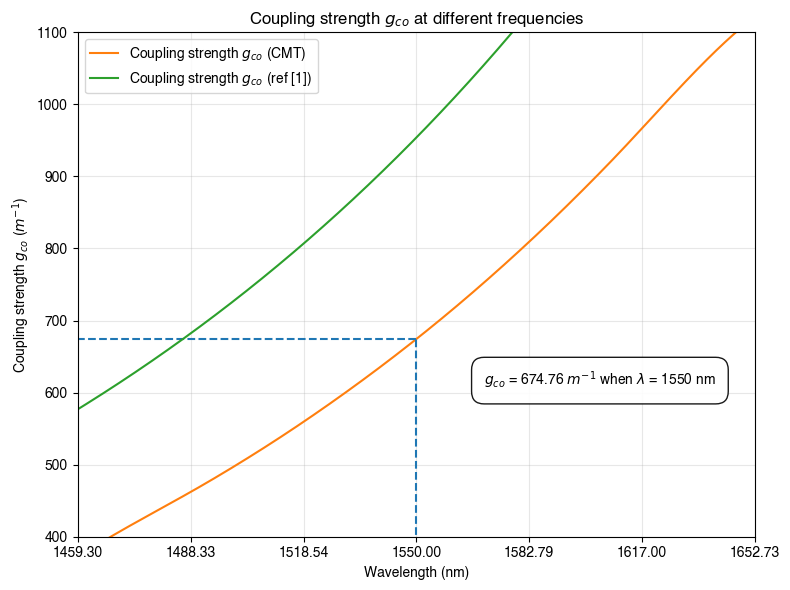

In [68]:
# m is proportional to frequency, which is inversely proportional to wavelength
m_arr_intp_flipped = np.flip(m_arr_intp)

# mark the point where g0 is
g0              = g_arr_intp[np.argmin(np.abs(0 - m_arr_intp))]
idx             = np.argmin(np.abs(m_arr_intp_flipped))
horizontal_y    = np.ones(np.shape(m_arr_intp_flipped))[idx:] * g0
horizontal_x    = m_arr_intp_flipped[idx:]
vertical_y      = np.linspace(np.min(g_arr_intp),g0,1000)
vertical_x      = np.ones(np.shape(vertical_y))* 0

# exponential fit according to the reference [1]
m_g             = 1196
g0_exp          = 954
g_arr_exp       = g0_exp * np.exp(-m_arr_intp / m_g)

data_arr        = (np.c_[m_arr_intp_flipped, g_arr_intp],
                   np.c_[vertical_x,vertical_y],
                   np.c_[horizontal_x,horizontal_y],
                   np.c_[m_arr_intp_flipped, g_arr_exp]
                   )
data_label_arr  = [r"Coupling strength $g_{co}$ (CMT)","","",
                   r"Coupling strength $g_{co}$ (ref [1])"]*3

linestyle_list  = ["-","--","--"]*3
xticks          = np.arange(-Max_M_idx,Max_M_idx+1)*M
xtickslabels    = np.array(["{:.2f}".format(c / (freq_1550 + D_ave/(2*np.pi) * xtick) * 1e9) for xtick in xticks])
colors_list     = ['tab:orange']+['tab:blue']*2+['tab:green']*2+['black']*10
text            = r"$g_{co}$" + r" = {:.2f} ".format(g0)+r"$m^{-1}$ when $\lambda$ = 1550 nm"
param_dict      = {"Y_legends": data_label_arr,
                    "X_label"     : r'Wavelength (nm)',
                    "Y_label"     : r"Coupling strength $g_{co}$ ($m^{-1}$)",
                    "title"       : r"Coupling strength $g_{co}$ at different frequencies",
                    "figsize"     : (8,6),
                    "marker_list" : [""]*15,
                    "linestyle_list": linestyle_list,
                    "colors_list" : colors_list,
                    "xticks"      : xticks,
                    "xtickslabel" : np.flip(xtickslabels),
                    "xlim"        : (np.min(xticks),np.max(xticks)),
                    "ylim"        : (400,1100),
                    "autoset_yticks"   : 0,
                    "text"        : text,
                    "loc_text"    : (0.6,0.3),
                    "AD_region_color"  : False,
                    "foldername"   : foldername
                    }

Plot_curve(data_arr,**param_dict)

## Analyze the resonant frequency and dispersion of 2D parallel racetracks

In [69]:
'''
Plot the resonant frequency with and without coupling

Parameters:
vernier_param_arr       : the parameters of the vernier structure. format:(D1,D2,D_ave,M,Max_M_idx)
coupled_data_arr        : the data of the coupled curves
coupled_data_label_arr  : the label of the coupled curves
param_dict_             : the parameters of the plot that are different from the default
num_of_pts              : the number of points on X axis
'''
def Resonant_freq_plot(vernier_param_arr, coupled_data_arr=[], coupled_data_label_arr=[], param_dict_={}, num_of_pts=100):

    m_arr = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts).reshape(-1,1)
    M0 = 0
    Y_legends = []

    # Resonant frequency of resonator 1
    Y_data = np.array(D1 * (m_arr - M0))
    Y_legends.append(r"Resonator1 $\omega = \omega_0$+$(D_1-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D1 * (m_arr - M0) + m*D_ave
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator1 $\omega$ = $\omega_0$+$(D_1-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D1 * (m_arr - M0) - m*D_ave
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")

    # Resonant frequency of resonator 2
    Y = D2 * (m_arr - M0)
    Y_data = np.c_[Y_data,Y]
    Y_legends.append(r"Resonator2 $\omega = \omega_0$+$(D_2-D_{ave})$(m-$M_0$)")
    for m in range(1,Max_M_idx):
        Y = D2 * (m_arr - M0) +  m*D_ave
        Y_data = np.c_[Y_data,Y]
        Y_legends.append(r"Resonator2 $\omega$ = $\omega_0$+$(D_2-D_{ave})$(m-$M_0$)$\pm$"+str(m)+r"$D_{ave}$")
        Y = D2 * (m_arr - M0) -  m*D_ave
        Y_data = np.c_[Y_data,Y]
        Y_legends.append("")

    # The contribution of average FSR is deducted to make the differences more obvious
    Y_data = Y_data - D_ave * (m_arr - M0)

    # Resonant frequencies with coupling
    if np.size(coupled_data_arr) != 0:
        Y_data = np.c_[Y_data,coupled_data_arr]
        Y_legends = Y_legends + coupled_data_label_arr

    # Default plot settings, can be changed with param_dict
    linestyle_name_list = ["dashed","dotted"]*3
    linestyle_list      = ["-"]
    for i in range(Max_M_idx-1):
        for j in range(2):
            linestyle_list.append(linestyle_name_list[i])
    linestyle_list = linestyle_list + linestyle_list
    linestyle_list = linestyle_list + ["-"]*30
    colors_list = ['lightskyblue']*(Max_M_idx*2-1)+ ['lightcoral']*(Max_M_idx*2-1)\
                    +['orange']*2+['dodgerblue']*2+['black']*30
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
    xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"  for xtick in xticks]
    xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
    xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
    param_dict = {  "Y_legends"       : Y_legends,
                    "X_label"         : 'mode number m',
                    "Y_label"         : r"Frequency $\omega$/(2$\pi$) (GHz)",
                    "xticks"          : xticks,
                    "xtickslabel"     : xtickslabels,
                    "title"           : "Mode number non-conservation coupling",
                    "marker_list"     : [""]*30,
                    "linestyle_list"  : linestyle_list,
                    "colors_list"     : colors_list,
                    "xlim"            : (-Max_M_idx*M,Max_M_idx*M),
                    "bbox_legend"     : (1.05,0.6)}
    if len(param_dict_)>0:
        for key,value in param_dict_.items():
            param_dict[key] = value

    data_arr = (np.c_[m_arr,Y_data/1e9/(2*np.pi)],)

    Plot_curve(data_arr,**param_dict)

In [70]:
# g : Array of coupling strength at different wavelengths
def Reson_freq(m,D1,g,L,epsilon):
    return D1/(2*np.pi)*np.arccos(np.cos(g*L)*np.cos(2*np.pi * epsilon *m))

# Analytical dispersion formula given by CMT.
# Refrence: Ji QX, Liu P, Jin W, et al. Multimodality integrated microresonators using the Moiré speedup effect. Science. 2024;383(6687):1080-1083. doi:10.1126/science.adk9429
def FSR_func(m,D_ave,g,L,epsilon):
    return epsilon * D_ave/(2*np.pi)* np.cos(g*L)*np.sin(2*np.pi * epsilon *m) /(1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**0.5

# Analytical dispersion formula given by CMT.
# Refrence: Yuan Z, Gao M, Yu Y, et al. Soliton pulse pairs at multiple colours in normal dispersion microresonators. Nat Photon. 2023;17(11):977-983. doi:10.1038/s41566-023-01257-2
def Dispersion_ana(m,D_ave,g,L,epsilon):
    return D_ave *(2*np.pi)* epsilon**2 *np.cos(g*L) *np.sin(g*L)**2 * np.cos(2*np.pi*epsilon*m) /(1-np.cos(g*L)**2 * np.cos(2*np.pi * epsilon *m)**2)**1.5

# Numerical dispersion curve calculated using propagation constant data
def Dispersion_num(m,reson_freq):
    FSR = First_derivative_central_diff(reson_freq,m)
    return First_derivative_central_diff(FSR,m[1:-1])

In [71]:
# Calculate the anomalous dispersion range around 1550nm of 2D parallel coupled rings (unit: nm)
def AD_range_func(m_arr,D_arr,M,FSR):
    zero_list,zero_idx_list = find_zero(m_arr, D_arr)
    zero_list               = np.array(zero_list)
    zero_list_m_0           = zero_list[np.where(np.abs(zero_list) < M)]      # zeros around mode numer m = 0
    zero_list_m_0_p         = zero_list_m_0[zero_list_m_0>0]
    zero_list_m_0_m         = zero_list_m_0[zero_list_m_0<0]
    if len(zero_list_m_0_p) > 0 and  len(zero_list_m_0_m) > 0 and D_arr[np.argmin(np.abs(m_arr))] > 0:
        return (np.min(zero_list_m_0_p) - np.max(zero_list_m_0_m))*FSR * 1e-9 /100 * 0.8
    else:
        return 0

In [72]:
def epsilon_func(L1,L2):
    return (L2-L1)/(L1+L2)

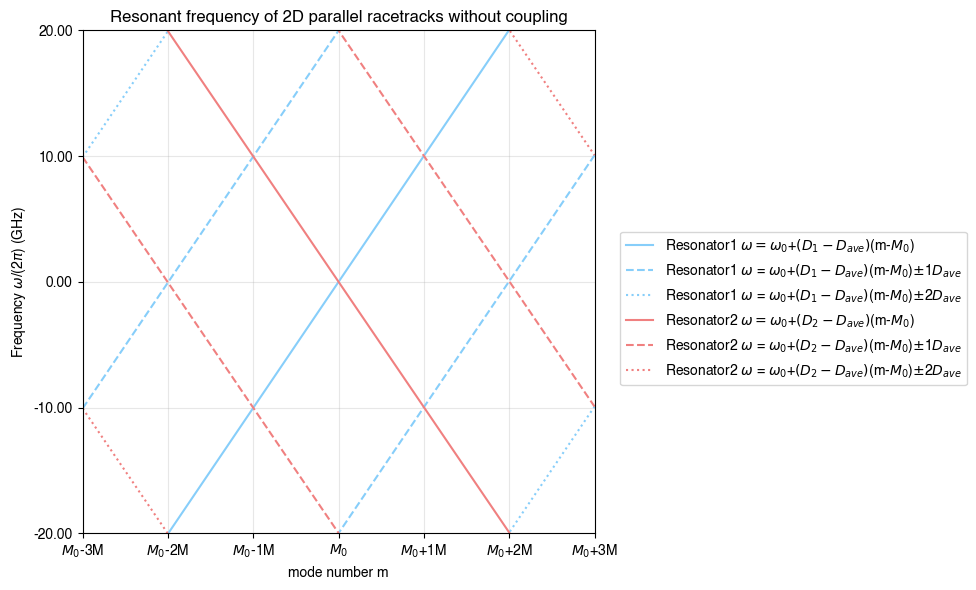

In [73]:
vernier_param_arr = (D1, D2, D_ave, M, Max_M_idx)
param_dict  = {
    "title"         : "Resonant frequency of 2D parallel racetracks without coupling",
    "ylim"          : (-20,20),
    "foldername"    : "./results/2D parallel racetracks/"
}
Resonant_freq_plot(vernier_param_arr,
                    param_dict_ = param_dict,
                    num_of_pts= num_of_pts)

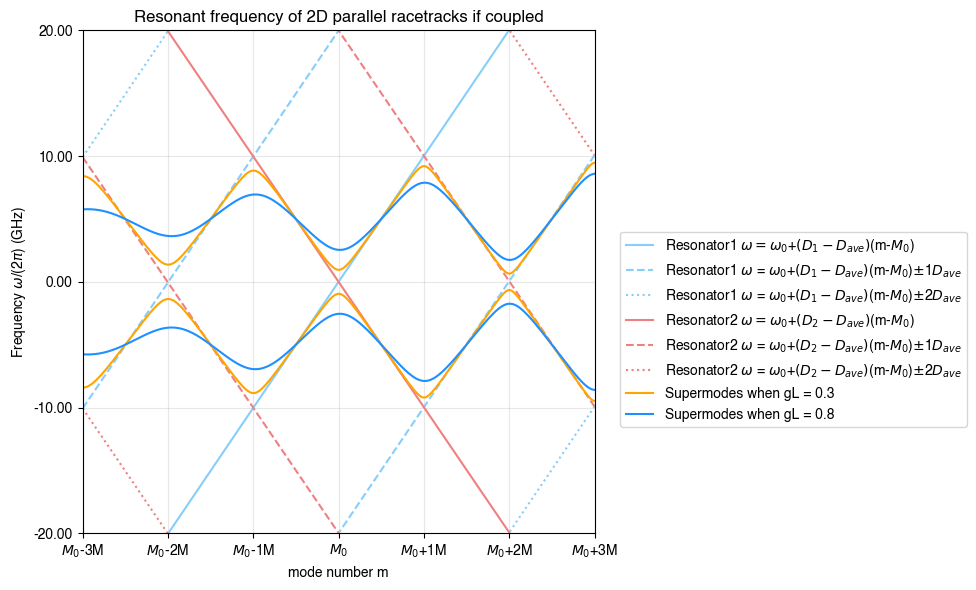

In [74]:
L_small_coupling    = 0.3 / g0
Y_p_Small           = Reson_freq(m_arr_intp,D_ave,g_arr_intp,L_small_coupling,epsilon)
Y_m_Small           = -Reson_freq(m_arr_intp,D_ave,g_arr_intp,L_small_coupling,epsilon)
L_large_coupling    = 0.8 /g0
Y_p_Large           = Reson_freq(m_arr_intp,D_ave,g_arr_intp,L_large_coupling,epsilon)
Y_m_Large           = -Reson_freq(m_arr_intp,D_ave,g_arr_intp,L_large_coupling,epsilon)
data_arr            = np.c_[Y_p_Small,Y_m_Small,Y_p_Large,Y_m_Large]
data_label_arr      = ["","Supermodes when gL = "+"{:.1f}".format(g0*L_small_coupling)
                        ,"","Supermodes when gL = "+"{:.1f}".format(g0*L_large_coupling)]
param_dict  = {
    "alpha_list"     : [1]*14+[0.6,0.6]+[1]*4,
    "ylim"          : (-20,20),
    "title"         : "Resonant frequency of 2D parallel racetracks if coupled",
    "foldername"    : "./results/2D parallel racetracks/"
}
Resonant_freq_plot(vernier_param_arr,
                    coupled_data_arr=data_arr,
                    coupled_data_label_arr=data_label_arr,
                    param_dict_ = param_dict,
                    num_of_pts=num_of_pts)


In [75]:
# Dispersion of isolated resonator

# D_iso   = -668                                # unit: ps/nm/km
# n_g     = 1.59367
# beta_2  = -1550**2/(2*np.pi*c) * D_iso *1e-9  # unit: ps^2/nm
# D_2     = -c* (D_ave*1e-12)**2* beta_2 / n_g  # unit: 2pi * GHz
# D_2o    = D_2*1e9                             # unit: Hz

D_2o    = -283 *1e3 * 2*np.pi                   # unit: Hz

D_iso   = D_2o * np.ones(np.shape(m_arr_intp[2:-2]))

In [76]:
D_small_couple      = Dispersion_num(m_arr_intp,Y_p_Small)
D_large_couple      = Dispersion_num(m_arr_intp,Y_p_Large)

AD_range = AD_range_func(m_arr_intp[2:-2],D_large_couple+D_iso,
         M = M, FSR = D_ave/(2*np.pi))
AD_range

np.float64(16.613866557595887)

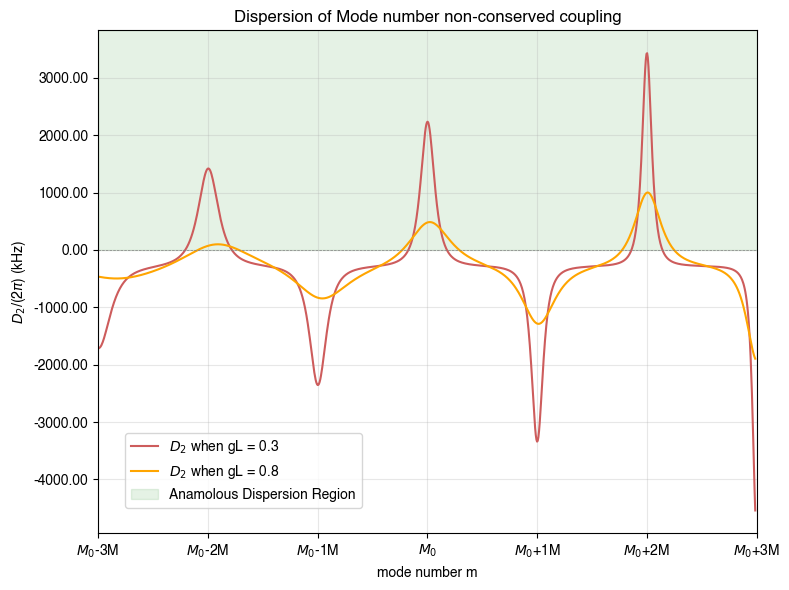

In [77]:
data_arr        = np.c_[D_small_couple+D_iso,D_large_couple+D_iso]
data_arr        = (np.c_[m_arr_intp[2:-2],data_arr/1e3/(2*np.pi)],)
data_label_arr  = [r"$D_2$ when gL = "+"{:.1f}".format(L_small_coupling*g0),
                  r"$D_2$ when gL = "+"{:.1f}".format(L_large_coupling*g0),
                  r"$D_{2,o}$ (dispersion of uncoupled resonator)"]

color_list   = ['indianred']+['Orange']+['tab:blue']+['tab:green']*2+['black']*10
# color_list   = ['navy']+['royalblue']+['tab:green']*2+['black']*10
linestyle_list = ["-"]*10

xticks       = np.arange(-Max_M_idx,Max_M_idx+1)
xtickslabels = [("$M_0$+" if xtick>0 else "$M_0$") + str(xtick) + "M"
                for xtick in xticks]
xtickslabels[int(len(xtickslabels)/2)] = "$M_0$"
xticks       = np.arange(-Max_M_idx,Max_M_idx+1)*M
yticks       = Auto_ticks(data_arr)
param_dict   = {"Y_legends"     : data_label_arr,
                "X_label"       :'mode number m',
                "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
                "title"         : "Dispersion of Mode number non-conserved coupling",
                "figsize"       : (8,6),
                "marker_list"   : [""]*15,
                "linestyle_list": linestyle_list,
                "colors_list"   : color_list,
                "xticks"        : xticks,
                "xtickslabel"   : xtickslabels,
                "yticks"        : yticks,
                "xlim"          : (-Max_M_idx*M,(Max_M_idx)*M),
                # "ylim"          : (-2000,2000),
                "AD_region_color"    : True,
                "bbox_legend"   :(0.4,0.2),
                "foldername"    : foldername
                }
Plot_curve(data_arr,**param_dict)



In [78]:
gL_product_arr  = np.arange(0.1,1.6,0.01)
Lco_arr         = gL_product_arr  / g0

AD_range_arr = []
for Lco in Lco_arr:
    Reson_freq_arr =Reson_freq(m_arr_intp,D_ave,g_arr_intp,Lco,epsilon)
    D_coupled_arr  = Dispersion_num(m_arr_intp,Reson_freq_arr)
    AD_range_res   = AD_range_func(m_arr_intp[2:-2], D_coupled_arr + D_iso,
                                    M = M, FSR = D_ave/(2*np.pi))
    AD_range_arr.append(AD_range_res)

AD_range_arr         = np.array(AD_range_arr)

max_AD_range         = np.max(AD_range_arr)
max_idx              = np.argmax(AD_range_arr)
max_AD_range_arr_y   = np.ones(np.shape(gL_product_arr))[:max_idx] * max_AD_range
max_AD_range_arr_x   = gL_product_arr[:max_idx]
max_idx_range_arr_y  = np.linspace(0,max_AD_range,1000)
max_idx_range_arr_x  = np.ones(np.shape(max_idx_range_arr_y))*gL_product_arr[max_idx]


## Find the maximum anomalous dispersion range of 2D parallel racetracks

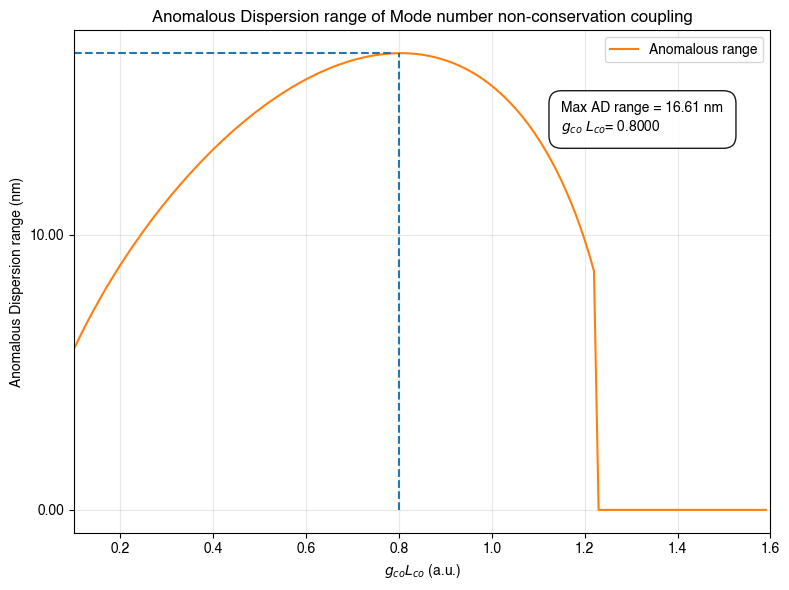

In [79]:
data_arr        = (np.c_[gL_product_arr, AD_range_arr],
                   np.c_[max_AD_range_arr_x,max_AD_range_arr_y],
                   np.c_[max_idx_range_arr_x,max_idx_range_arr_y],)
data_label_arr  = [r"Anomalous range","",""]*3
linestyle_list  = ["-","--","--"]*3
text            = "Max AD range = {:.2f} nm\n".format(max_AD_range) +\
                r'$g_{co}$ $L_{co}$' +'= {:.4f}'.format(gL_product_arr[max_idx])
param_dict = {"Y_legends" : data_label_arr,
            "X_label"     : r'$g_{co} L_{co}$ (a.u.)',
            "Y_label"     : r"Anomalous Dispersion range (nm)",
            "title"       : "Anomalous Dispersion range of Mode number non-conservation coupling",
            "figsize"     : (8,6),
            "marker_list" : [""]*15,
            "linestyle_list":linestyle_list,
            "colors_list" : ['tab:orange']+['tab:blue']*2+['tab:green']*2+['black']*10,
            "xlim"        : (0.1,1.6),
            # "ylim"        : (0,21),
            "AD_region_color"  : False,
            "text"        : text,
            "loc_text"    : (0.7,0.8),
            "foldername"  : foldername
            }
Plot_curve(data_arr,**param_dict)


In [82]:
gL_product_arr  = np.arange(0.1,1.6,0.01)
L2_ratio_arr    = np.arange(1.001,1.011,0.0001)
# L2_ratio_arr    = np.linspace(L2/L1, L2/L1 ,1)
epsilon_arr     = epsilon_func(L1, L1*L2_ratio_arr)
Lco_arr         = gL_product_arr  / g0_exp
AD_range_arr    = []
for L2_ratio in L2_ratio_arr:
    L2      = L1 * L2_ratio
    D1      = c/(ng_1550 * L1) *2* np.pi
    D2      = c/(ng_1550 * L2) *2* np.pi
    D_ave   = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
    # D_ave = D1 * 0.99
    epsilon = (L2-L1)/(L1+L2)
    FSR = (D1-D2)/(2*epsilon)
    M = 1/(2*epsilon)

    AD_range_arr_given_L2 = []
    for Lco in Lco_arr:
        Reson_freq_arr = Reson_freq(m_arr_intp,D_ave,g_arr_exp,Lco,epsilon)
        D_coupled_arr  = Dispersion_ana(m_arr_intp,D_ave,g_arr_exp,Lco,epsilon)
        D_iso   = D_2o * np.ones(np.shape(m_arr_intp))
        AD_range_res = AD_range_func(m_arr_intp, D_coupled_arr + D_iso,
                                        M = M, FSR = D_ave/(2*np.pi))
        AD_range_arr_given_L2.append(AD_range_res)

    AD_range_arr.append(AD_range_arr_given_L2)

AD_range_arr    = np.array(AD_range_arr)


In [83]:
flat_index = np.argmax(AD_range_arr)
max_index = np.unravel_index(flat_index, np.shape(AD_range_arr))
np.array(max_index)

array([47, 75])

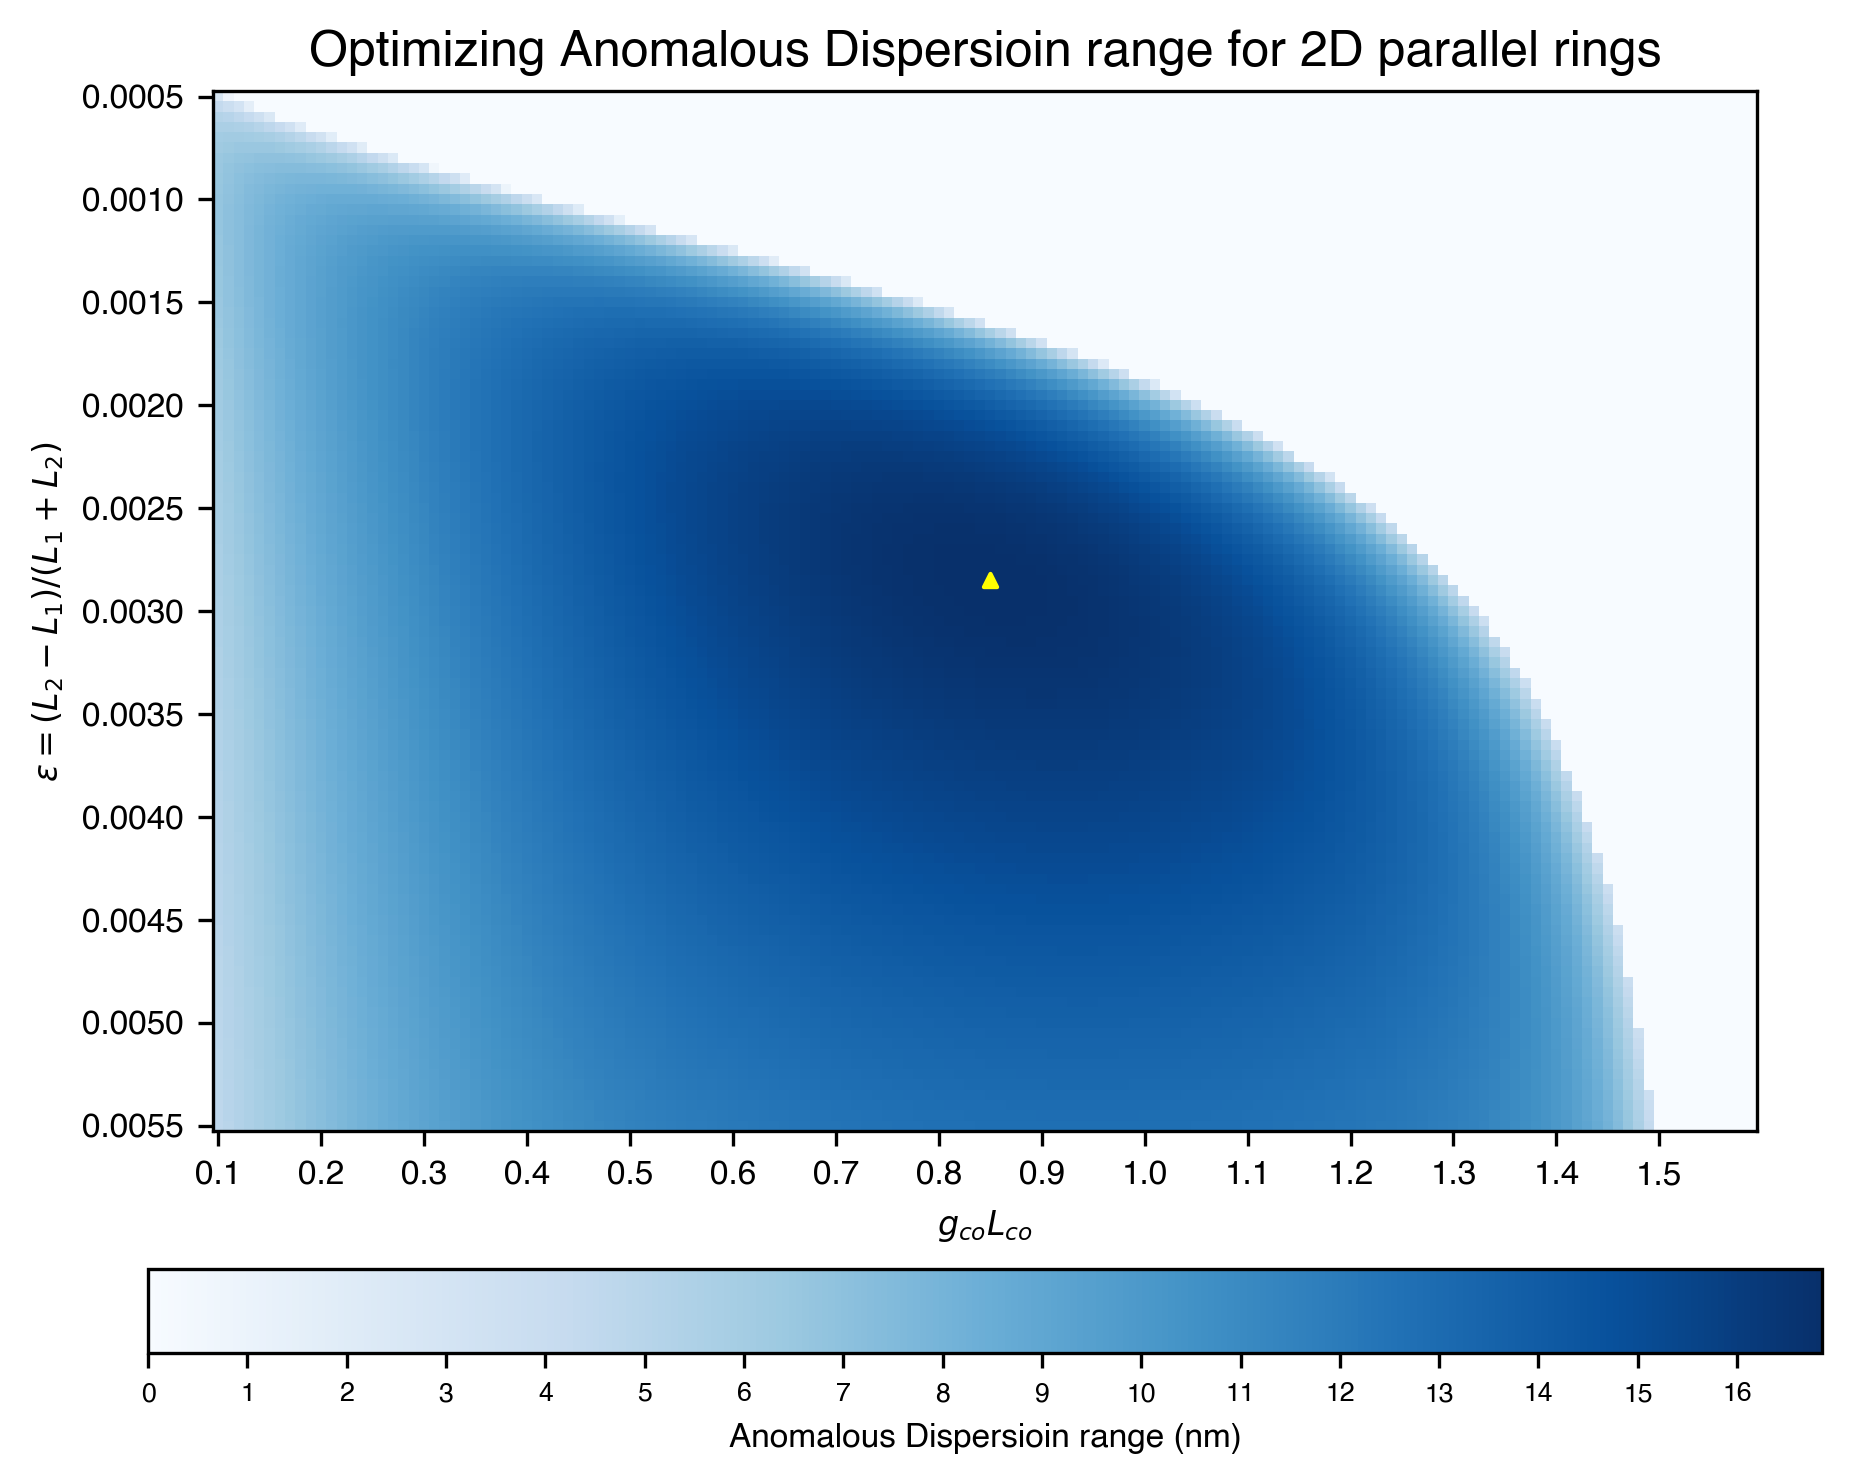

In [84]:
xticks = np.arange(0,len(gL_product_arr),10)
yticks = np.arange(0,len(epsilon_arr),10)
param_dict = {
        "point_color"   : 'yellow',
        "aspect"        : 1,
        "xlabel"        : r"$g_{co}L_{co}$",
        "ylabel"        : r"$\epsilon = (L_2-L_1)/(L_1+L_2)$",
        "cbar_label"    : "Anomalous Dispersioin range (nm)",
        "cbar_small_ticks" : True,
        "figsize"       : (8,6),
        "title"         : "Optimizing Anomalous Dispersioin range for 2D parallel rings",
        "xticks"        : xticks,
        "yticks"        : yticks,
        "xtickslabel"   : ["{:.1f}".format(gL) for gL in gL_product_arr[xticks]],
        "ytickslabel"   : ["{:.4f}".format(ep) for ep in epsilon_arr[yticks]],
        "fontsize"      : 8,
        "foldername"    : foldername
}
Plot_im(AD_range_arr,
        point_arr = np.flip(np.array(max_index).reshape(1,2)),
        **param_dict)

#### largest Anomalous Dispersion (AD) range

In [85]:
AD_range_arr[max_index]

np.float64(16.856805640174795)

#### parameters when AD range is maximized

In [86]:
# best g_co * L_co
best_gL = gL_product_arr[max_index[1]]
best_gL

np.float64(0.8499999999999996)

In [87]:
best_epsilon = epsilon_arr[max_index[0]]

In [88]:
# best ratio L2/L1
best_L2 = (1+best_epsilon) / ( 1-best_epsilon) * L1
(1+best_epsilon) / ( 1-best_epsilon)

np.float64(1.0056999999999994)

In [89]:
# Difference of the FSR of the two rings
(3*1e8/(1.6*L1) - 3*1e8/(1.6*best_L2))/1e9      #unit: GHz

np.float64(0.11186238440885544)

In [90]:
# Best coupling length Lco
best_gL/g0 * 1e3     #unit: mm

np.float64(1.2597083390271788)

## Draw the optimized dispersion curve when AD range is maximum

In [91]:
# Optimized parameters
L2                  = L1 * (1+best_epsilon) / ( 1-best_epsilon)
D2                  = c/(ng_1550 * L2) *2* np.pi
D_ave               = c/(ng_1550 * (L1+L2)/2) *2 *np.pi
L_best_coupling     = best_gL/g0
epsilon             = (L2-L1)/(L1+L2)
M                   = 1/(2*epsilon)

In [92]:
# Plot settings
Max_M_idx   = 2
m_arr_intp  = np.linspace(-Max_M_idx*M, Max_M_idx*M, num_of_pts)

In [93]:
D_best_couple       = Dispersion_ana(m_arr_intp,D_ave,g_arr_intp,L_best_coupling,best_epsilon)
D_iso               = D_2o * np.ones(np.shape(m_arr_intp))

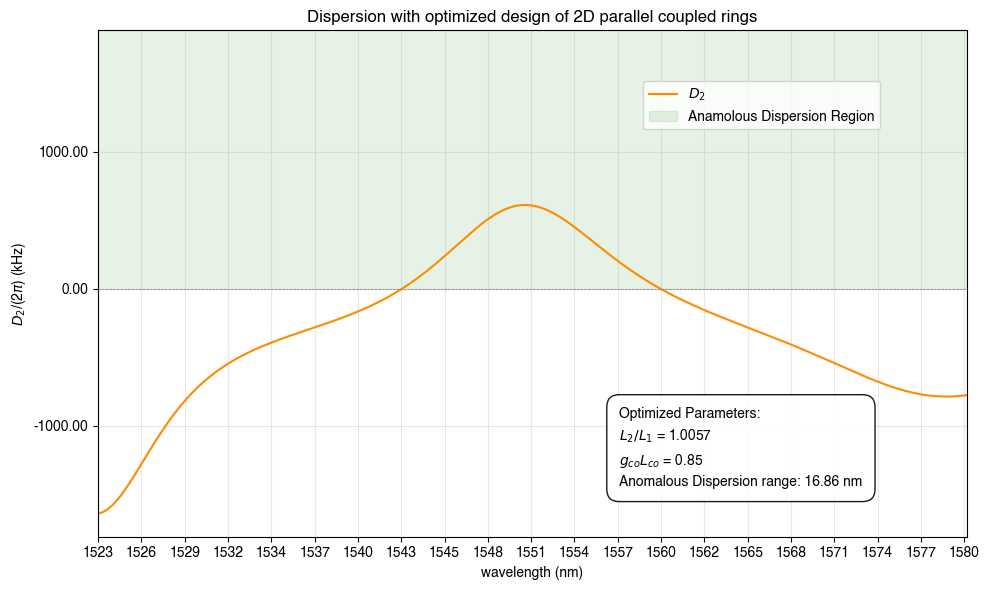

In [94]:
text           = "Optimized Parameters: \n"+ \
                r"$L_2/L_1$ = {:.4f}".format((1+best_epsilon) / ( 1-best_epsilon)) +"\n" +\
                r"$g_{co}L_{co}$ = "+"{:.2f}".format(best_gL) + "\n"+\
                "Anomalous Dispersion range: {:.2f} nm".format(AD_range_arr[max_index])

data_arr       = np.flip(np.c_[D_best_couple +D_iso],axis=0)
data_label_arr = [r"$D_2$"]
linestyle_list = ["-"]*10

data_arr     = (np.c_[m_arr_intp, data_arr/1e3/(2*np.pi)],)
xticks       = np.arange(-Max_M_idx,Max_M_idx+0.1, 0.1)*M
xtickslabels = np.array(["{:.0f}".format(3*1e8 / (freq_1550 + D_ave/(2*np.pi) * xtick) * 1e9) for xtick in xticks])
yticks       = Auto_ticks(data_arr)
param_dict = {
    "Y_legends"     : data_label_arr,
    "X_label"       : 'wavelength (nm)',
    "Y_label"       : r"$D_2$/(2$\pi$) (kHz)",
    "title"         : "Dispersion with optimized design of 2D parallel coupled rings",
    "figsize"       : (10,6),
    "marker_list"   : [""]*15,
    "linestyle_list": linestyle_list,
    "colors_list"   : ["DarkOrange"]+['Orange'],
    "xticks"        : xticks,
    "xtickslabel"   : np.flip(xtickslabels),
    "yticks"        : yticks,
    "xlim"          : (-Max_M_idx*M/2,(Max_M_idx)*M/2+1),
    # "ylim"          : (-2500,3000),
    "AD_region_color"    : True,
    "bbox_legend"   : (0.9,0.9),
    "text"          : text,
    "linespacing"   : 1.5,
    "loc_text"      : (0.6,0.1),
    "foldername"    : foldername
}
Plot_curve(data_arr,**param_dict)